# **Gruid Translator**
To the extent possible under law, the person who associated CC0 with **Gruid Translator** has waived
all copyright and related or neighboring rights to **Gruid Translator**.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

sys.path.insert(0, "../src")
import constants as c
import file_io as io
import gemcevent_handler as gemc_eh
import gruidevent_handler as gruid_eh

In [11]:
# INFILE = "/home/twig/data/code/babycal/bcal_generator/out/bcal_20210413093129_r101c51.txt" # 101x51 muon 10 GeV
# INFILE = "/home/twig/data/code/babycal/bcal_generator/out/bcal_20210419184231_r101c51.txt" # 101x51 muon  1 GeV
INFILE = "/home/twig/data/code/babycal/bcal_generator/out/bcal_20210420093253_r101c51.txt" # 101x51 electron 0.1 GeV
# INFILE = "/home/twig/data/code/babycal/bcal_generator/out/bcal_20210414101055_r7c7.txt"    # 7x7 1000 muons
# INFILE = "/home/twig/data/code/babycal/bcal_generator/out/bcal_20210414151313_r7c7.txt"    # 7x7 10000 neutrons
dt = 0.5
dx = 0.1
dy = 0.125
fevent = 1
nevents = 1000
nrows = None
ncols = None

In [12]:
# Load gemc file
(path, filename) = io.split_address(INFILE)
if nrows is None and ncols is None: (nrows, ncols) = io.decode_filename(filename)
(metadata, events) = io.load_file(INFILE, fevent, nevents)

# Store and process hits
ei = fevent
gemchitsdict  = {}
gruidhitsdict = {}
for event in events:
    key = filename + ' ' + c.S_EVENT + ' ' + str(ei)
    gemchitsdict[key]  = gemc_eh.extract_hits(event)
    gruidhitsdict[key] = gruid_eh.generate_event(gemchitsdict[key], nrows, ncols, dt, dx, dy)
    ei += 1

### Plot matrices in time series

t = 0.0


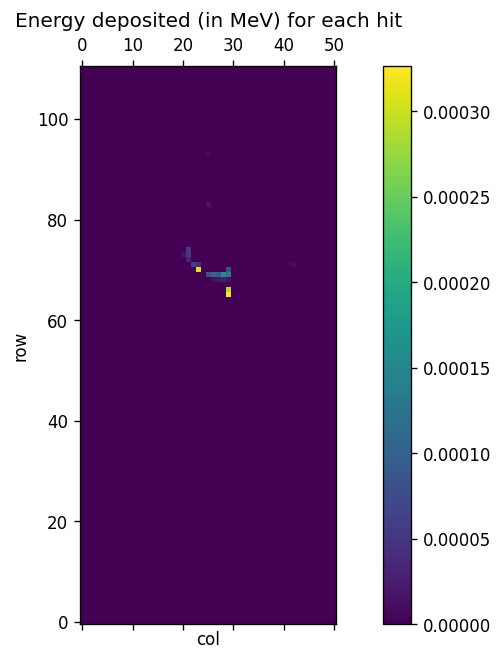

In [13]:
# Select last event
en = -1
for k in gruidhitsdict.keys():
    ei = int(k.split(' ')[-1])
    if ei > en: en = ei
k = filename + ' ' + c.S_EVENT + ' ' + str(ei)

# Store the time series
gruid_nrows = gruidhitsdict[k][c.S_GRUIDMETA][c.S_NROWS]
gruid_ncols = gruidhitsdict[k][c.S_GRUIDMETA][c.S_NCOLS]
m     = {c.S_GRUIDH1: {}, c.S_GRUIDH2: {}}
sum_m = {}

for side in m.keys():
    for t in gruidhitsdict[k][side].keys():
        m[side][t] = np.zeros([gruid_nrows, gruid_ncols])
        sum_m[t]   = np.zeros([gruid_nrows, gruid_ncols])
        for loc in gruidhitsdict[k][side][t]:
            (x,y) = map(int, loc.split(','))
            m[side][t][y,x] = gruidhitsdict[k][side][t][loc]
            sum_m[t][y,x]  += gruidhitsdict[k][side][t][loc]

# Draw plots
for t in m[c.S_GRUIDH1].keys():
    print("t = " + str(round(t, 3)))
    plt.figure(num=1, figsize=(10, 6), dpi=120, facecolor='w', edgecolor='k')
    plt.matshow(sum_m[t], fignum=1, origin="lower")
    plt.colorbar()
    plt.title("Energy deposited (in MeV) for each hit")
    plt.xlabel("col")
    plt.ylabel("row")
    plt.show()

### Count number of fibers hit by massive particles

In [ ]:
for ei in range(len(events)):
    event = events[ei]
    fibhits = [] # Count fibers hit
    for hi in range(len(event[c.IDBANK][c.S_HITN])):
        if event[c.IRBANK][c.S_EDEP][hi] == '0': continue # Ignore events with not energy deposited
        if event[c.IRBANK][c.S_PID][hi] not in [c.S_MMPID, c.S_MPPID, c.S_NPID]: continue # Ignore photon hits

        volhit = event[c.IDBANK][c.S_VOL][hi]
        volid = int(int(volhit)/10**8)
        if int(int(volhit)/10**8) in (1, 11) and volhit not in fibhits:
            fibhits.append(volhit)
    print("Event %d: %d volumes hit." % (ei+1, len(fibhits)))

### Get avg_t distribution

In [ ]:
tarr = []
for k1 in gemchitsdict.keys():
    tM = 0
    for k2 in gemchitsdict[k1].keys():
        if k2 == c.S_MASSHITS: continue
        for t in gemchitsdict[k1][k2][c.S_T]:
            if t > tM: tM = t
            t = gemchitsdict[k1][k2][c.S_T]
    tarr.append(tM)
print("avg:    %f\nstddev: %f\nmin:    %f\nmax:    %f" %
          (np.average(tarr), np.std(tarr), np.amin(tarr), np.amax(tarr)))

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='k')
plt.hist(tarr, bins=20)
plt.show()

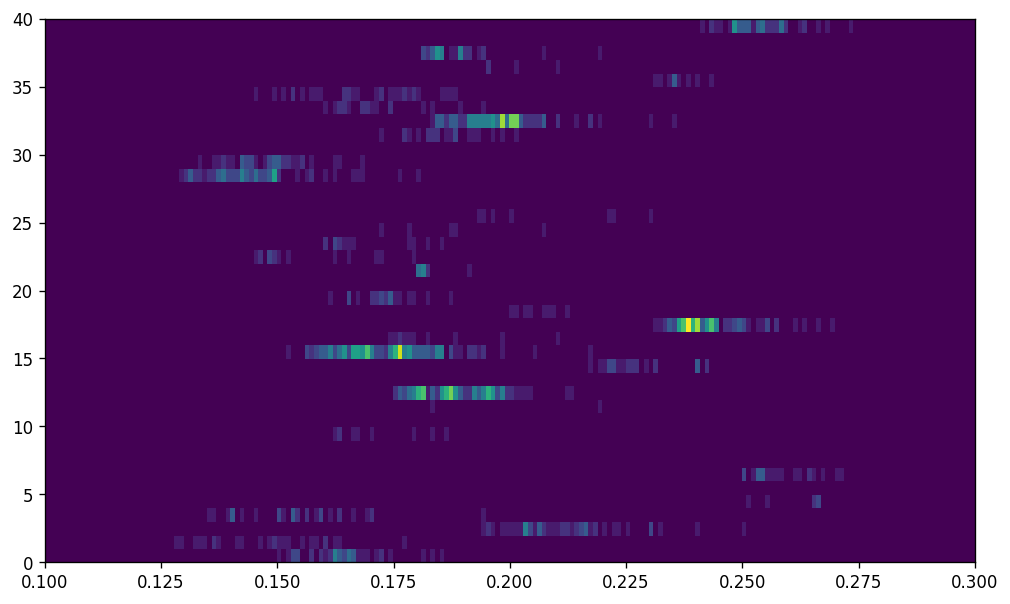

In [7]:
import random
nevents = 40

tarr = []
for k1 in gemchitsdict.keys():
    tarr.append([])
    for k2 in gemchitsdict[k1].keys():
        if k2 in [c.S_MASSHITS, c.S_PHOTONH1]: continue
        for t in gemchitsdict[k1][k2][c.S_T]:
            tarr[-1].append(t)

x = []
y = []
eventcounter = 0
for i in random.sample(range(0, 500), nevents):
    for t in tarr[i]:
        x.append(t)
        y.append(eventcounter)
    eventcounter += 1

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='k')
plt.hist2d(x, y, bins=(200,nevents), range=((0.1,0.3), (0,nevents)))
plt.show()